In [1]:
import pandas as pd
pd.options.mode.copy_on_write = True
import seaborn as sns
import re
from tqdm import tqdm
import os
import numpy as np
from matplotlib_venn import venn3
import matplotlib.pyplot as plt
# from palaeoPSM.psm_read import FragPipeRun, filter_psms
# from palaeoPSM.psm_to_long import psm_to_long
from Bio import SeqIO
import re
from lxml import etree
from pyteomics import parser
# from upsetplot import from_contents, UpSet

In [2]:
save_folder = '../fish_orthrus_results/'

In [3]:
exp_design = pd.read_csv('../briquettes_exp_design.csv')

exp_design['clay'] = exp_design['clay'].map({'A3': 'Aegina', 'R': 'Commercial'})

exp_design['label'] = exp_design['clay'] + ' + ' + exp_design['temper'] + ' - ' + exp_design['firing']
exp_design['fabric'] = exp_design['clay'] + ' + ' + exp_design['temper']
exp_design = exp_design.sort_values(['cooking', 'sample' ,'firing'])
exp_design.loc[exp_design['sample']=='blank_1', 'label'] = 'blank_1'
exp_design.loc[exp_design['sample']=='blank_2', 'label'] = 'blank_2'
exp_design.loc[exp_design['sample']=='blank_1', 'fabric'] = 'blank_1'
exp_design.loc[exp_design['sample']=='blank_2', 'fabric'] = 'blank_2'

In [4]:
exp_design

,sample,clay,clay_name,temper,firing,cooking,label,fabric
0,fish_1A,Aegina,Aegina (A3),quartz,low T,anchovy,Aegina + quartz - low T,Aegina + quartz
1,fish_1B,Aegina,Aegina (A3),quartz,high T,anchovy,Aegina + quartz - high T,Aegina + quartz
2,fish_2A,Aegina,Aegina (A3),none,low T,anchovy,Aegina + none - low T,Aegina + none
3,fish_2B,Aegina,Aegina (A3),none,high T,anchovy,Aegina + none - high T,Aegina + none
4,fish_3A,Commercial,Commercial (R),quartz,low T,anchovy,Commercial + quartz - low T,Commercial + quartz
5,fish_3B,Commercial,Commercial (R),quartz,high T,anchovy,Commercial + quartz - high T,Commercial + quartz
6,fish_5A,Commercial,Commercial (R),high Ca grog,low T,anchovy,Commercial + high Ca grog - low T,Commercial + high Ca grog
7,fish_6A,Commercial,Commercial (R),low Ca grog,low T,anchovy,Commercial + low Ca grog - low T,Commercial + low Ca grog
8,fish_7A,Commercial,Commercial (R),straw,low T,anchovy,Commercial + straw - low T,Commercial + straw
9,fish_8A,Commercial,Commercial (R),none,low T,anchovy,Commercial + none - low T,Commercial + none


In [5]:
def count_n_scans(n_scans_path):
    if os.path.isfile(n_scans_path):
        print(f'Reading # of scans from {n_scans_path}')
        ext = os.path.splitext(n_scans_path)[1]
        if ext == '.csv':
            sep = ','
        elif ext == '.tsv':
            sep = '\t'
        else:
            sys.exit(f'{n_scans_path} is not recognised as a csv or tsv file')
        n_scans = pd.read_csv(n_scans_path, sep=sep)
    elif os.path.isdir(n_scans_path):
        print(f'Reading mzML files from {n_scans_path} and counting # of scans')
        mzml_files = [f for f in os.listdir(n_scans_path) if f.endswith('.mzML')]
        scan_counts = []
        for f in mzml_files:
            sample = f.rstrip('.mzML')
            print(f'\tReading sample {sample} ... ', end='')
            path = os.path.join(n_scans_path, f)
            tree = etree.parse(path)
            root = tree.getroot()
            ms1spectra = root.xpath(
                "mzml:mzML/mzml:run/mzml:spectrumList/mzml:spectrum"
                "[mzml:cvParam/@name='ms level' and mzml:cvParam/@value='1']",
                namespaces={'mzml': 'http://psi.hupo.org/ms/mzml'})
            ms2spectra = root.xpath(
                "mzml:mzML/mzml:run/mzml:spectrumList/mzml:spectrum"
                "[mzml:cvParam/@name='ms level' and mzml:cvParam/@value='2']",
                namespaces={'mzml': 'http://psi.hupo.org/ms/mzml'})
            scan_counts.append([sample, len(ms1spectra), len(ms2spectra)])
            print('Done')
        n_scans = pd.DataFrame(scan_counts, columns=['sample', 'n_ms1scans', 'n_ms2scans'])
        n_scans_file = os.path.join(n_scans_path, 'n_scans.csv')
        print(f'Writing # of scans on {n_scans_file}')
        n_scans.to_csv(n_scans_file, index=False)
    else:
        warnings.warn(f'{n_scans_path} is not recognised as a csv or tsv file, or a directory to mzML files.\n'
                      f'n_scans set to None.')
        n_scans = None
    return n_scans

In [6]:
n_scans = count_n_scans('../mzml_data_fish/n_scans.csv')

Reading # of scans from ../mzml_data_fish/n_scans.csv


In [7]:
exp_design = exp_design.merge(n_scans, on='sample', how='right')

In [8]:
exp_design = exp_design.sort_values('sample')

In [9]:
contams = '../databases/contams.fasta'
contams_dict = SeqIO.to_dict(SeqIO.parse(contams, "fasta"))

milk_db = '../databases/DB1_bovin_ArchaeocRAP3.2.fasta'
milk_db_dict = SeqIO.to_dict(SeqIO.parse(milk_db, "fasta"))

contams_dict.update(milk_db_dict)

In [10]:
fish_muscle = '../orthrus_db/fish_combined_pt1.fasta'
fish_muscle_dict = {}
for r in SeqIO.parse(fish_muscle, 'fasta'):
    fish_muscle_dict[r.id] = r

In [11]:
pt1_fasta_dir = '../orthrus_db/orthrus_pt1/'
if os.path.isfile(os.path.join(pt1_fasta_dir, '../combined_pt1.fasta')):
    reduced_db = SeqIO.to_dict(
        SeqIO.parse(os.path.join(pt1_fasta_dir, '../combined_pt1.fasta'), "fasta"))
else:
    reduced_db = {}
    for f in tqdm(os.listdir(pt1_fasta_dir)):
        if not f.endswith('fasta'):
            continue
        f = os.path.join(pt1_fasta_dir, f)
        f_dict = SeqIO.to_dict(SeqIO.parse(f, "fasta"))
        reduced_db.update(f_dict)
    SeqIO.write(
        list(reduced_db.values()),
        os.path.join(pt1_fasta_dir, '../combined_pt1.fasta'),
        'fasta'
    )

In [12]:
gene_names = {}
gn_re = re.compile(r'GN=(.+?) ')
for seqid, r in reduced_db.items():
    m = gn_re.search(r.description)
    if m is not None:
        gene_names[seqid] = m.group(1)

## Plot settings

In [13]:
# Define colors for fabrics
briquette_colors = {
    'blank_1': '#DDDDDD',
    'blank_2': '#DDDDDD',
    'Aegina + quartz - low T': '#CC6677',
    'Aegina + quartz - high T': '#CC6677',
    'Aegina + none - low T': '#999933',
    'Aegina + none - high T': '#999933',
    'Commercial + quartz - low T': '#AA4499',
    'Commercial + quartz - high T': '#AA4499',
    'Commercial + high Ca grog - low T': '#44AA99',
    'Commercial + low Ca grog - low T': '#88CCEE',
    'Commercial + straw - low T': '#117733',
    'Commercial + none - low T': '#DDCC77',
    'Commercial + none - high T': '#DDCC77',
}


briquette_colors = {
    'blank_1': '#DDDDDD',
    'blank_2': '#DDDDDD',
    'Aegina + quartz - low T': '#CC6677', 
    'Aegina + quartz - high T': '#801f2d',
    'Aegina + none - low T': '#c3c33b',
    'Aegina + none - high T': '#897b38',
    'Commercial + quartz - low T': '#cb3cb4',
    'Commercial + quartz - high T': '#853e7a',
    'Commercial + high Ca grog - low T': '#44AA99',
    'Commercial + low Ca grog - low T': '#88CCEE',
    'Commercial + straw - low T': '#117733',
    'Commercial + none - low T': '#e4e268',
    'Commercial + none - high T': '#b7b72e',#8e953a
    'empty': '#dddddd'
}


fabric_colors = {
    'blank_1': '#DDDDDD',
    'blank_2': '#DDDDDD',
    'Aegina + quartz': '#CC6677',
    'Aegina + none': '#999933',
    'Commercial + quartz': '#AA4499',
    'Commercial + high Ca grog': '#44AA99',
    'Commercial + low Ca grog': '#88CCEE',
    'Commercial + straw': '#117733',
    'Commercial + none': '#DDCC77',
}


fabric_hatch = {
    '1A': '...',
    '1B': '',
    '2A': '...',
    '2B': '',
    '3A': '...',
    '3B': '',
    '5A': '...',
    '6A': '...',
    '7A': '...',
    '8A': '...',
    '8B': ''
}

hatches = ['1A', '1B', '2A', '2B',
           '3A', '3B', '5A', '6A', '7A', '8A', '8B']

# Read Orthurs Mokapot results

In [14]:
mokapot_results = '../orthrus_results/narrow_search/'
mokapot_psms = pd.read_csv(
    os.path.join(mokapot_results, 'mokapot.psms.txt'), sep='\t')
mokapot_peptides = pd.read_csv(
    os.path.join(mokapot_results, 'mokapot.peptides.txt'), sep='\t')

## Remove contams, decoys and above 0.05 FDR

We will remove any psm or peptide matched to a keratin or a non-fish collagen

In [15]:
def filter_prots(prot_list, contams, whitelist):
    for p in prot_list:
        if p.startswith('rev_'):
            return False
        if p in contams:
            return False
        if p in whitelist:
            return True
    return False


def clean_mokapot(df, fdr, contams, whitelist):
    # Filter by FDR
    df = df.loc[df['mokapot PEP'] < 0.95, :]
    # Filter proteins
    df.loc[:,'Proteins'] = df['Proteins'].str.split(';')
    df.loc[:,'keep_pept'] = df['Proteins'].apply(lambda x: filter_prots(x, contams, whitelist))
    df = df.loc[df['keep_pept'], :]
    # Remove extension from filename to get the sample
    df[['sample', 'ext']] = df['FileName'].str.split('.', expand=True)
    # Add column with unmodified peptide
    ptm_re = re.compile('\[.+\]')
    df['Unmod_Peptide'] = df['Peptide'].apply(lambda x: re.sub(ptm_re, '', x))
    return df

In [16]:
mokapot_psms = clean_mokapot(mokapot_psms, 0.05, contams_dict, fish_muscle_dict)
mokapot_peptides = clean_mokapot(mokapot_peptides, 0.05, contams_dict, fish_muscle_dict)

In [17]:
peptides_count = mokapot_peptides.groupby('sample')['ScanNr'].agg('count')

In [18]:
psms_count = (
    mokapot_psms
    .groupby('sample')['ScanNr'].agg('count')
    .reset_index()
    .merge(exp_design, on='sample', how='right')
    .rename(columns={'ScanNr': 'count_ids'}))
psms_count['prop_ids'] = psms_count['count_ids'] / psms_count['n_ms2scans']

In [19]:
psms_count

,sample,count_ids,clay,clay_name,temper,firing,cooking,label,fabric,n_ms1scans,n_ms2scans,prop_ids
0,blank_1,18.0,NaN,blank,blank,blank,blank,blank_1,blank_1,1285,6616,0.002721
1,blank_2,19.0,NaN,nlank,blank,blank,blank,blank_2,blank_2,1393,6324,0.003004
2,control_1A,1.0,Aegina,Aegina (A3),quartz,low T,control,Aegina + quartz - low T,Aegina + quartz,1468,6106,0.000164
3,control_1B,NaN,Aegina,Aegina (A3),quartz,high T,control,Aegina + quartz - high T,Aegina + quartz,1352,6433,NaN
4,control_2A,9.0,Aegina,Aegina (A3),none,low T,control,Aegina + none - low T,Aegina + none,1314,6537,0.001377
5,control_2B,1.0,Aegina,Aegina (A3),none,high T,control,Aegina + none - high T,Aegina + none,1295,6607,0.000151
6,control_3A,5.0,Commercial,Commercial (R),quartz,low T,control,Commercial + quartz - low T,Commercial + quartz,1574,5945,0.000841
7,control_3B,21.0,Commercial,Commercial (R),quartz,high T,control,Commercial + quartz - high T,Commercial + quartz,1315,6466,0.003248
8,control_5A,1.0,Commercial,Commercial (R),high Ca grog,low T,control,Commercial + high Ca grog - low T,Commercial + high Ca grog,1270,6644,0.000151
9,control_6A,23.0,Commercial,Commercial (R),low Ca grog,low T,control,Commercial + low Ca grog - low T,Commercial + low Ca grog,1281,6611,0.003479


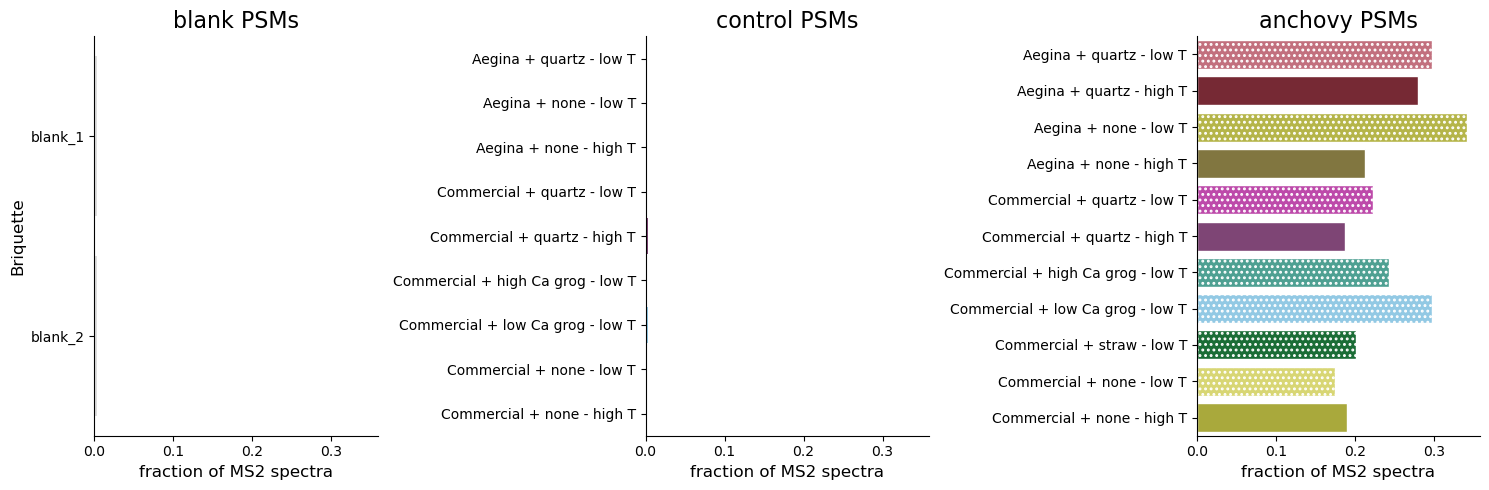

In [25]:
p1 = sns.catplot(
    psms_count,
    y='label', x='prop_ids', col='cooking', hue='label',
    palette=briquette_colors, orient='h', saturation=0.8,
    kind='bar', sharey=False, legend_out=True)
p1.set_titles(col_template="{col_name} PSMs", size=16)
p1.set_ylabels("Briquette", size=12)
p1.set_xlabels("fraction of MS2 spectra", size=12)
p1.fig.set_figwidth(15)

for i in range(11):
    p1.axes[0,2].patches[i].set_hatch(fabric_hatch[hatches[i]])
    p1.axes[0,2].patches[i].set_hatch_linewidth(1.3)
    p1.axes[0,2].patches[i].set_edgecolor('white')
# p1.legend.remove()
# export_legend(p3.legend, os.path.join(save_folder, 'briquettes_legends'))
# p3.axes[0,2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
p1.fig.tight_layout()

/tmp/ipykernel_33896/31844171.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  p1.axes[0,0].set_yticklabels(p1.axes[0,0].get_yticklabels(), size=16)
/tmp/ipykernel_33896/31844171.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  p1.axes[0,0].set_xticklabels(p1.axes[0,0].get_xticklabels(), size=14)


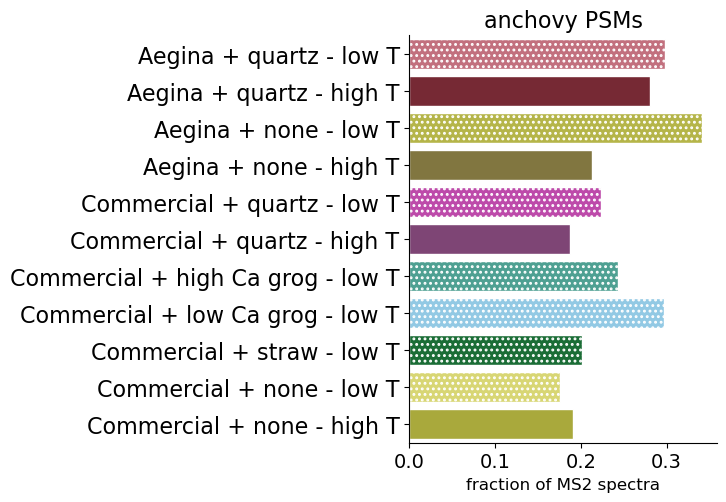

In [33]:
p1 = sns.catplot(
    psms_count.query('cooking == "anchovy"'),
    y='label', x='prop_ids', col='cooking', hue='label',
    palette=briquette_colors, orient='h', saturation=0.8,
    kind='bar', sharey=False, legend_out=True)
p1.set_titles(col_template="{col_name} PSMs", size=16)
p1.set_ylabels("", size=12)
p1.set_xlabels("fraction of MS2 spectra", size=12)
p1.fig.set_figwidth(8)

p1.axes[0,0].set_yticklabels(p1.axes[0,0].get_yticklabels(), size=16)
p1.axes[0,0].set_xticklabels(p1.axes[0,0].get_xticklabels(), size=14)

for i in range(11):
    p1.axes[0,0].patches[i].set_hatch(fabric_hatch[hatches[i]])
    p1.axes[0,0].patches[i].set_hatch_linewidth(1.3)
    p1.axes[0,0].patches[i].set_edgecolor('white')
# p1.legend.remove()
# export_legend(p3.legend, os.path.join(save_folder, 'briquettes_legends'))
# p3.axes[0,2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
# p1.fig.tight_layout()
p1.fig.savefig(save_folder + '/ids_spectra.png', format='png')
p1.fig.savefig(save_folder + '/ids_spectra.svg', format='svg')

# Coverage

In [90]:
muscle_proteins = [
    ("ACTB", "Actin, cytoplasmic 1"),
    ("ATP2A1", "Sarcoplasmic/endoplasmic reticulum calcium ATPase 1"),
    ("ATP5F1B", "ATP synthase subunit beta, mitochondrial precursor"),
    ("ATP6", "ATP synthase subunit a"),
    ("CACNA1S", "Calcium Voltage-Gated Channel Subunit Alpha1 S"),
    ("CAMK2G", "Calcium/Calmodulin Dependent Protein Kinase II Gamma"),
    ("CKMT2", "Creatine kinase, testis isozyme"),
    ("COL1A1", "Collagen type I alpha 1 chain"),
    ("COL1A2", "Collagen type I alpha 2 chain"),
    ("COL2A1", "Collagen type II alpha 1 chain"),
    ("COL3A1", "Collagen type III alpha 1 chain"),
    ("COL5A1", "Collagen type V alpha 1 chain"),
    ("COL5A2", "Collagen type V alpha 2 chain"),
    ("CS", "Citrate synthase, mitochondrial precursor"),
    ("ELOVL5", "ELOVL Fatty Acid Elongase 5"),
    ("FABP3", "Fatty Acid Binding Protein 3"),
    ("FABP4", "Fatty Acid Binding Protein 4"),
    ("FASN", "Fatty Acid Synthase"),
    ("HBA", "Hemoglobin cathodic subunit alpha"),
    ("HBB", "Hemoglobin subunit beta"),
    ("LDHA", "L-lactate dehydrogenase A chain"),
    ("LDHB", "L-lactate dehydrogenase B chain"),
    ("MB", "Myoglobin"),
    ("MC4R", "Melanocortin 4 Receptor"),
    ("MYH4", "Myosin heavy chain, fast skeletal muscle"),
    ("MYH6", "Atrial myosin heavy chain"),
    ("MYH9A", "Myosin-9a"),
    ("MYH11A", "Myosin-11a"),
    ("MYLPFA", "Myosin regulatory light chain 2, skeletal muscle isoform A"),
    ("PPP1R12A", "Protein phosphatase 1 regulatory subunit 12A"),
    ("MYLK3", "Myosin light chain kinase 3"),
    ("MYO6A", "Unconventional myosin-VI"),
    ("TPI1", "Triosephosphate isomerase"),
    ("TPM1", "Tropomyosin-1 alpha chain"),
    ("MYH9B", "Myosin-9b"),
    ("MYL1", "Myosin light chain 3, skeletal muscle isoform"),
    ("MYLIPA", "E3 ubiquitin-protein ligase MYLIP-A"),
    ("MYO1C", "Unconventional myosin-Ic"),
    ("MYO1D", "Unconventional myosin-Id"),
    ("MYO5B", "Myosin VB"),
    ("MYO6B", "Unconventional myosin-VI"),
    ("MYO9AA", "Unconventional myosin-IXAa"),
    ("MYO9AB", "Unconventional myosin-IXAb"),
    ("NDPKB", "Nucleoside diphosphate kinase B"),
    ("PDE3B", "Phosphodiesterase 3B"),
    ("PRKAG3", "Protein Kinase AMP-Activated Non-Catalytic Subunit Gamma 3"),
    ("PVALB", "Parvalbumin beta"),
    ("PVALB2", "Parvalbumin-2"),
    ("PVALB7", "Parvalbumin-7"),
    ("PVALB8", "Parvalbumin-8"),
    ("PVALB9", "Parvalbumin-9"),
    ("RYR1", "Ryanodine Receptor 1")
]

In [91]:
peptides_bysample = mokapot_peptides.groupby('sample')

sample_prot_coverage = []
for sample in tqdm(peptides_bysample.groups):
    protein_peptides = {}
    sample_df = peptides_bysample.get_group(sample)
    proteins = sample_df['Proteins'].values
    peptides = sample_df['Unmod_Peptide'].values
    for i in range(len(peptides)):
        p = peptides[i]
        pep_prots = proteins[i]
        for prot in pep_prots:
            if prot not in protein_peptides:
                protein_peptides[prot] = {p}
            else:
                protein_peptides[prot].update(p)
    for prot, peptides in protein_peptides.items():
        g = gene_names.get(prot, '')
        g = g.upper()
        prot_seq = str(reduced_db[prot].seq)
        prot_length = len(prot_seq)
        prot_cov_exact = parser.coverage(prot_seq, peptides)
        sample_prot_coverage.append((sample, prot, prot_cov_exact*100, prot_length, g))

100%|███████████████████████████████████████████| 17/17 [00:03<00:00,  4.56it/s]


In [92]:
coverage_df = pd.DataFrame(
    sample_prot_coverage,
    columns = ['sample', 'protein', 'coverage', 'protein_length', 'gene_name'])


In [93]:
coverage_df['protein_name'] = (
    coverage_df['protein'].apply(lambda x: x.split('|')[2].split('_')[0]))

In [96]:
coverage_df.query('protein_name == "TPM1"')

,sample,protein,coverage,protein_length,gene_name,protein_name
208,fish_1A,sp|P04268|TPM1_CHICK,99.647887,284,TPM1,TPM1
209,fish_1A,sp|P04692|TPM1_RAT,98.943662,284,TPM1,TPM1
212,fish_1A,sp|P09493|TPM1_HUMAN,98.943662,284,TPM1,TPM1
214,fish_1A,sp|P13104|TPM1_DANRE,99.647887,284,TPMA,TPM1
215,fish_1A,sp|P13105|TPM1_RANTE,99.647887,284,TPM1,TPM1
...,...,...,...,...,...,...
19393,fish_8B,sp|Q5KR49|TPM1_BOVIN,79.577465,284,TPM1,TPM1
19596,fish_8B,sp|P13104|TPM1_DANRE,45.070423,284,TPMA,TPM1
19597,fish_8B,sp|P13105|TPM1_RANTE,44.366197,284,TPM1,TPM1
19599,fish_8B,sp|P84335|TPM1_CHEAU,42.957746,284,,TPM1


In [66]:
muscle_proteins = {
    'sp|Q90339|MYSS_CYPCA': 'myosin\nheavy chain\nfast skeletal\nmuscle',
    #'tr|A0A8C8BSV0|A0A8C8BSV0_ONCTS': 'myosin\nheavy chain 6',
    'tr|A0A8C2JNZ0|A0A8C2JNZ0_CYPCA': 'myosin\nlight chain 1',
    # 'sp|P79818|ACTB_ORYLA': 'actin 1',
    'sp|P49055|ACTS_CARAU': 'actin alpha\nskeletal muscle',
    'sp|P13104|TPM1_DANRE': 'tropomyosin-1'
}


other_proteins = {
    'sp|P02594|CALM_ELEEL': 'calmodulin',
    'sp|Q9PVM4|HBAA_SERQU': 'hemoglobin\nalpha',
    'sp|Q9PVM2|HBBA_SERQU': 'hemoglobin\nbeta',
    'tr|Q5NT96|Q5NT96_PAROL': 'col1a1'
}



In [67]:
def report_gene_coverage(coverages, prot_lengths):
    max_length = prot_lengths.max()
    max_coverage = coverages[prot_lengths > 0.9*max_length].max()
    lengths = prot_lengths[prot_lengths > 0.9*max_length]
    lengths = ';'.join(lengths.astype(str))
    return pd.Series([max_coverage, lengths])

In [68]:
coverage_bygene = (coverage_df
 .groupby(['sample', 'gene_name'])[['coverage', 'protein_length']]
 .apply(lambda x: report_gene_coverage(x['coverage'], x['protein_length']), include_groups=False)
 .reset_index()
 .rename(columns={0:'coverage', 1: 'lengths'}))

In [69]:
coverage_df.to_csv(save_folder + '/protein_coverage.csv', index=False)
coverage_bygene.to_csv(save_folder + '/protein_coverage_bygene.csv', index=False)

In [80]:
genes = ['TPM1', 'MYH4', 'MYL1', 'ACTB', 'COL1A1', 'COL1A2']

In [81]:
main_genes_cov = coverage_bygene.query('gene_name in @genes')

In [82]:
main_genes_cov = (
    main_genes_cov
    .merge(exp_design, on='sample', how='left')
    .query('cooking == "anchovy"'))

In [83]:
hatches = [
    '', '', '', '',
    'xxx', 'xxx', 'xxx', 'xxx',
    '', '', '', '',
    'xxx', 'xxx', 'xxx', 'xxx',
    '', '', '',
    'xxx', 'xxx', 'xxx',
    '', '', '',
    '', '', '', '',
    '', '', '', '',
    '', '', '', '',
    'xxx', 'xxx', 'xxx', 'xxx',
    '', 'xxx', '', 'xxx', '', 'xxx',
    '', '', '',
    '', 'xxx'
]

IndexError: list index out of range

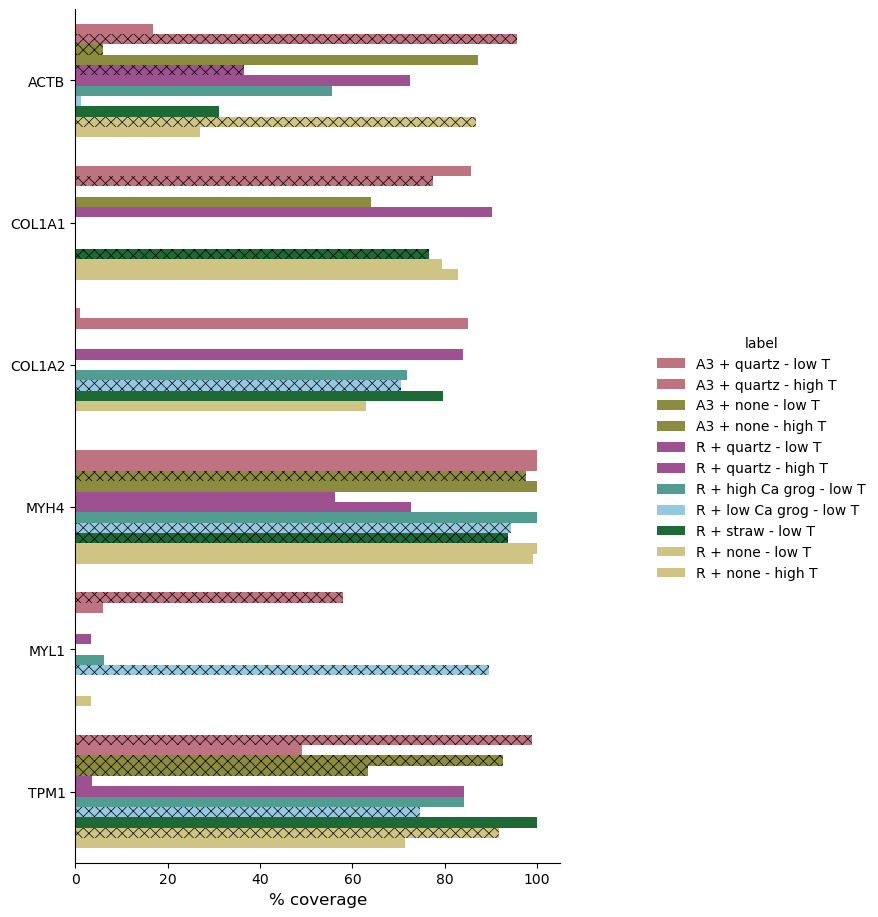

In [84]:
p5 = sns.catplot(
    main_genes_cov, y='gene_name', x='coverage', kind='bar', hue='label', palette=briquette_colors,
    orient='h', legend_out=True)
# p5.set_titles(col_template="{col_name} proteins coverage", row_template="{row_name}", size=16)
p5.fig.set_figwidth(10)
p5.fig.set_figheight(10)
p5.set_ylabels("", size=12)
p5.set_xlabels("% coverage", size=12)
for i in range(len(p5.axes[0,0].patches)):
    p5.axes[0,0].patches[i].set_hatch(hatches[i])
    p5.axes[0,0].patches[i].set_hatch_linewidth(0.5)

p5.axes[0,0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
p5.legend.remove()
# export_legend(p5.axes[0,1].get_legend(), os.path.join(save_folder, 'briquettes_legend'))
# p5.axes[0,1].get_legend().remove()
p5.fig.tight_layout()
p5.fig.savefig(save_folder + '/coverage_prot_2.png')